# **EXPERIMENT 3**
 
Data: GoEmotions 

## Import Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
import urllib.request
import zipfile
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Download Data

In [ ]:
!pip install wget
import wget

In [ ]:
emo2idx = {
    'admiration': 0,
    'amusement': 1,
    'anger': 2,
    'annoyance': 3,
    'approval': 4,
    'caring': 5,
    'confusion': 6,
    'curiosity': 7,
    'desire': 8,
    'disappointment': 9,
    'disapproval': 10,
    'disgust': 11,
    'embarrassment': 12,
    'excitement': 13,
    'fear': 14,
    'gratitude': 15,
    'grief': 16,
    'joy': 17,
    'love': 18,
    'nervousness': 19,
    'optimism': 20,
    'pride': 21,
    'realization': 22,
    'relief': 23,
    'remorse': 24,
    'sadness': 25,
    'surprise': 26,
    'neutral': 27
}
# text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral

if not os.path.exists('./goemotions/'):
    !wget -P goemotions/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
    !wget -P goemotions/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
    !wget -P goemotions/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

goemotions_1 = pd.read_csv('./goemotions/goemotions_1.csv', encoding='utf-8')
goemotions_2 = pd.read_csv('./goemotions/goemotions_2.csv', encoding='utf-8')
goemotions_3 = pd.read_csv('./goemotions/goemotions_3.csv', encoding='utf-8')

goemotions_raw = goemotions_1.append(goemotions_2).append(goemotions_3)
print(goemotions_raw.shape)
display(goemotions_raw.head())

goemotions_raw = goemotions_raw[goemotions_raw['example_very_unclear'] == False]
print(goemotions_raw.shape)
display(goemotions_raw.head())
            

(211225, 37)


text  ... neutral
0                                    That game hurt.  ...       0
1   >sexuality shouldn’t be a grouping category I...  ...       0
2     You do right, if you don't care then fuck 'em!  ...       1
3                                 Man I love reddit.  ...       0
4  [NAME] was nowhere near them, he was by the Fa...  ...       1

[5 rows x 37 columns]

(207814, 37)


text  ... neutral
0                                    That game hurt.  ...       0
2     You do right, if you don't care then fuck 'em!  ...       1
3                                 Man I love reddit.  ...       0
4  [NAME] was nowhere near them, he was by the Fa...  ...       1
5  Right? Considering it’s such an important docu...  ...       0

[5 rows x 37 columns]

In [ ]:
emo_list = ['admiration',
            'amusement',
            'anger',
            'annoyance',
            'approval',
            'caring',
            'confusion',
            'curiosity',
            'desire',
            'disappointment',
            'disapproval',
            'disgust',
            'embarrassment',
            'excitement',
            'fear',
            'gratitude',
            'grief',
            'joy',
            'love',
            'nervousness',
            'optimism',
            'pride',
            'realization',
            'relief',
            'remorse',
            'sadness',
            'surprise',
            'neutral']

sum_class = np.zeros(len(emo_list))
for idx, row in goemotions_raw.iterrows():
    emo_class = row[9:].values
    sum_class = np.add(sum_class, emo_class)

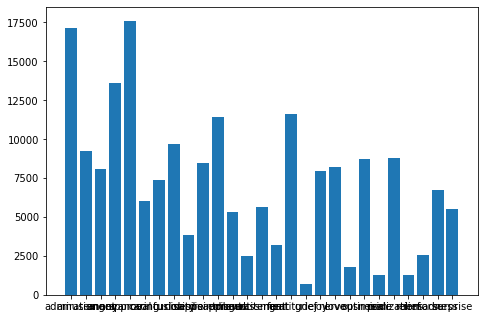

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(emo_list[:27], sum_class[:27])
fig.show()

In [ ]:
data_list = []

for _, row in goemotions_raw.iterrows():
    bin_arr = row[9:]
    emotions_idx = np.where(bin_arr == 1)
    emotions = ','.join([emo_list[idx] for idx in emotions_idx[0]])
    data_list.append([emotions, row['text']])

goemotions = pd.DataFrame(data_list, columns=['Emotion', 'Text'])
print(goemotions.shape)
display(goemotions.head(10))
df_balanced = goemotions[goemotions['Emotion'].isin(['neutral', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise'])]

(207814, 2)


Emotion                                               Text
0      sadness                                    That game hurt.
1      neutral     You do right, if you don't care then fuck 'em!
2         love                                 Man I love reddit.
3      neutral  [NAME] was nowhere near them, he was by the Fa...
4    gratitude  Right? Considering it’s such an important docu...
5  disapproval  He isn't as big, but he's still quite popular....
6    amusement  That's crazy; I went to a super [RELIGION] hig...
7    amusement                                that's adorable asf
8    amusement  "Sponge Blurb Pubs Quaw Haha GURR ha AAa!" fin...
9      neutral  I have, and now that you mention it, I think t...

## Data Preprocessing

In [ ]:
num_classes = 7
embed_num_dims = 300
max_seq_len = 500

class_names = ['neutral', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

In [ ]:
data_train, data_test = train_test_split(df_balanced, test_size=0.20, random_state=42)

X_train = data_train.Text
X_test = data_test.Text
y_train = data_train.Emotion
y_test = data_test.Emotion

data = data_train.append(data_test, ignore_index=True)

In [ ]:
def clean_text(data):
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    data = word_tokenize(data)
    
    return data

In [ ]:
texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)
index_of_words = tokenizer.word_index
vocab_size = len(index_of_words) + 1

In [ ]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

In [ ]:
encoding = {'neutral': 0, 
            'anger': 1, 
            'disgust': 2, 
            'fear': 3, 
            'joy': 4, 
            'sadness': 5, 
            'surprise': 6}

y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Word Embeddings

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1 
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [ ]:
fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)


In [ ]:
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

## Model

In [ ]:
kernel_size = 3
filters = 256

embedd_layer = Embedding(vocab_size, embed_num_dims, input_length = max_seq_len, weights = [embedd_matrix], trainable=False)
model = Sequential()
model.add(embedd_layer)
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          8055600   
                                                                 
 conv1d (Conv1D)             (None, 498, 256)          230656    
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 8,353,847
Trainable params: 298,247
Non-trainable params: 8,055,600
________________________________________

## Training

In [ ]:
batch_size = 256
epochs = 10

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/10
241/241 [==============================] - 542s 2s/step - loss: 0.8911 - accuracy: 0.7414 - val_loss: 0.7625 - val_accuracy: 0.7607
Epoch 2/10
241/241 [==============================] - 539s 2s/step - loss: 0.6830 - accuracy: 0.7781 - val_loss: 0.7125 - val_accuracy: 0.7727
Epoch 3/10
241/241 [==============================] - 536s 2s/step - loss: 0.6204 - accuracy: 0.7924 - val_loss: 0.7333 - val_accuracy: 0.7584
Epoch 4/10
241/241 [==============================] - 535s 2s/step - loss: 0.5622 - accuracy: 0.8060 - val_loss: 0.7347 - val_accuracy: 0.7701
Epoch 5/10
241/241 [==============================] - 534s 2s/step - loss: 0.5107 - accuracy: 0.8173 - val_loss: 0.7547 - val_accuracy: 0.7564
Epoch 6/10
241/241 [==============================] - 536s 2s/step - loss: 0.4621 - accuracy: 0.8263 - val_loss: 0.8032 - val_accuracy: 0.7407
Epoch 7/10
241/241 [==============================] - 533s 2s/step - loss: 0.4284 - accuracy: 0.8325 - val_loss: 0.8195 - val_accuracy: 0.7314

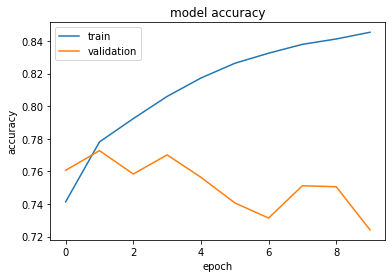

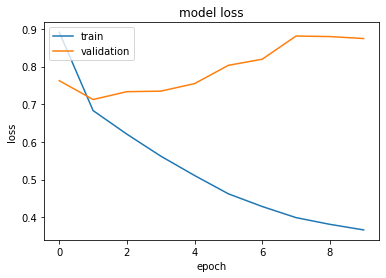

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Evaluation

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

Accuracy: 72.41%

F1 Score: 72.41


## Testing

In [ ]:
for x in X_test:
    print(x)
    print(X_test.iloc(0)[0])
    print('Message: {}\nPredicted: {}'.format(x, predictions[0]))
    break

??? Where the hell is this article getting it's data from...
??? Where the hell is this article getting it's data from...
Message: ??? Where the hell is this article getting it's data from...
Predicted: anger


## Done

In [ ]:
model.save('./exp-3/cnn-w2v')

INFO:tensorflow:Assets written to: ./drive/MyDrive/eecs595-final-project/exp-5/models/cnn-w2v/assets


In [ ]:
import tensorflow as tf

loaded_model = tf.keras.models.load_model('./exp-3/cnn-w2v')
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 300)          8055600   
                                                                 
 conv1d_2 (Conv1D)           (None, 498, 256)          230656    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 8,353,847
Trainable params: 298,247
Non-trainable params: 8,055,600
______________________________________